# Seasonality analysis

In [193]:
import os
import datetime as dt


import pandas as pd
from pandas_datareader import data as pdr

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

import yfinance as yf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import MSTL

from IPython.display import display, Markdown

import requests_cache
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter



class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass





# select the symbol to analyze

# symbol = '2B7K.DE'    # iShares MSCI World SRI UCITS ETF EUR (Acc)
# symbol = 'EUNL.DE'    # iShares Core MSCI World UCITS ETF USD (Acc)
# symbol = 'EURUSD=X'   # USD/EUR
# symbol = 'GBPUSD=X'   # GBP/USD
# symbol = 'AUDUSD=X'   # AUD/USD
# symbol = '^ATX'       # Austrian Traded Index in EUR
# symbol = 'ALV.DE'     # Allianz SE
# symbol = 'ADS.DE'     # adidas AG
symbol = 'EBAY'       # eBay Inc.
# symbol = 'AXP'        # American Express Company
# symbol = 'BTC-USD'    # Bitcoin USD
# symbol = 'ETH-USD'    # Ethereum USD
# symbol = '^GSPC'    # S&P 500




# set maximum number of years to analyze
max_num_of_years = 5



# show seasonality in % instead of currency
seasonalityInPercent = True




def D(text: str):
    display(Markdown(text))






D('## Analysis configuration:')
D(f'* **Symbol selected**: {symbol}')
D(f'* **Max years to analyse**: {dt.date.today().year-1} until earliest {dt.date.today().year-max_num_of_years}')


## Analysis configuration:

* **Symbol selected**: EBAY

* **Max years to analyse**: 2022 until earliest 2018

In [194]:
dirname = '.downloads'
historyFilename = f'{dirname}{os.path.sep}{symbol}_{dt.date.today()}.csv'
cacheFilename = f"{dirname}{os.path.sep}yfinance.cache"

os.makedirs(dirname, exist_ok=True)


session = CachedLimiterSession(
    limiter=Limiter(RequestRate(2, Duration.SECOND*5),  # max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket),
    backend=SQLiteCache(cacheFilename),
)
ticker = yf.Ticker(symbol, session=session)
df = ticker.history(period='max')

if not os.path.isfile(historyFilename):
    yf.pdr_override()  # <== that's all it takes :-)
    df = pdr.get_data_yahoo(tickers=[symbol], interval="1d")[['Close']]
    df.to_csv(historyFilename)
else:
    df = pd.read_csv(historyFilename, parse_dates=['Date'], index_col=['Date'])




D('## Data loaded:')
D(f'* Close prices of symbol _{symbol}_')
D(f'* From {df.index.min().strftime("%d.%m.%y")} to {df.index.max().strftime("%d.%m.%y")}')

#for (k, v) in ticker.info.items():
#    D(f'* {k}: {v}')

D('## Statistics:')
print(df.describe())
D('## Data:')
print(df)

## Data loaded:

* Close prices of symbol _EBAY_

* From 24.09.98 to 07.07.23

## Statistics:

             Close
count  6236.000000
mean     22.129993
std      15.997790
min       0.508558
25%      10.004209
50%      16.708754
75%      31.895000
max      80.589996


## Data:

                Close
Date                 
1998-09-24   0.830791
1998-09-25   0.786949
1998-09-28   0.846135
1998-09-29   0.857095
1998-09-30   0.790237
...               ...
2023-06-30  44.689999
2023-07-03  45.230000
2023-07-05  45.029999
2023-07-06  43.849998
2023-07-07  44.259998

[6236 rows x 1 columns]


In [201]:
annualDf = pd.DataFrame(data=df)
annualDf['Year'], annualDf['Day'] = annualDf.index.year, annualDf.index.strftime('%d. %b')

#annualDf = annualDf.reset_index().drop('Date', axis=1).set_index(['Year', 'Month_Day'])

firstDay = pd.to_datetime(str((annualDf.index.year.min()+1 if ((annualDf.index.year.max()-1) - (annualDf.index.year.min()+1)) < max_num_of_years else annualDf.index.year.max() - max_num_of_years)) + '-01-01')
lastDay = pd.to_datetime(str(annualDf.index.year.max()-1) + '-12-31')
range = pd.date_range(firstDay, lastDay, freq='D')
annualDf = annualDf[range.min():range.max()].reset_index().drop('Date', axis=1).set_index(['Year', 'Day'])
annualDf

#annualDf.query(f'Date >= {str(firstDay)}').query(f'Date <= {str(lastDay)}')

Close
Year Day               
2018 02. Jan  38.060001
     03. Jan  39.220001
     04. Jan  38.570000
     05. Jan  39.689999
     08. Jan  39.799999
...                 ...
2022 23. Dec  40.169998
     27. Dec  40.080002
     28. Dec  39.919998
     29. Dec  41.820000
     30. Dec  41.470001

[1259 rows x 1 columns]

In [196]:
#rolling_resolution = 200

#df.index = pd.to_datetime(df.index)
#df = df.asfreq('d')                 # set correct frequency
#df = df.fillna(method='ffill')      # fill up missing values

#df['Year'] = df.index.year
#df.index = df.index.strftime('%d. %b')
#df = df[['Year', 'Close']]
#df.reset_index()

#annualDf.drop_duplicates()
#annualDf.reset_index(drop=True)
#annualDf.reindex(pd.MultiIndex.from_frame(df, names=['Date', 'Year']))

#annualDf = pd.DataFrame()
#numOfYears = 0
#for year in sorted(list(set(df.index.year)), reverse=True)[1:-1]:
#    numOfYears += 1
#    if numOfYears > max_num_of_years:
#        break
#    curYearValues = df[str(year) + '-01-01':str(year) + '-12-31']['Close'].values
#    if curYearValues.size == 366:
#        curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
#    annualDf[str(year)] = curYearValues

#resultMean = annualDf.mean(axis=1)
#resultMin = annualDf.min(axis=1)
#resultMax = annualDf.max(axis=1)
#annualDf['mean'] = resultMean
#annualDf['min'] = resultMin
#annualDf['max'] = resultMax

#lastYear = dt.date.today().year-1
#range = pd.date_range(str(lastYear) + '-01-01', str(lastYear) + '-12-31', freq='D')
#annualDf['date'] = range
#annualDf = annualDf.set_index('date')

# annualDf.index = resultDf.index.strftime('%d. %b')

#D('## Initial data overview')
#annualDf
#annualDfIndex


In [197]:
#periods = [4, 12, 52, 365]
#periodNames = ['seasonal_' + str(i) for i in periods]

#decompose = MSTL(df['Close'], periods=periods)
#decompose = decompose.fit()

#numOfYears = 0
#retDf = pd.DataFrame()
#for year in sorted(list(set(decompose.seasonal[periodNames[3]].index.year)), reverse=True)[1:-1]:
#    numOfYears += 1
#    if numOfYears > max_num_of_years:
#        break
#    curYearValues = decompose.seasonal[periodNames[3]][str(year) + '-01-01':str(year) + '-12-31'].values
#    if curYearValues.size == 366:
#        curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
#    #annualDf[periodNames[3] + '_' + str(year)] = curYearValues

#D('## Seasonal decomposition')
#annualDf

In [198]:
#monthlyDf = pd.DataFrame()
#numOfYears = 0
#for year in sorted(list(set(decompose.seasonal.index.year)), reverse=True)[1:-1]:
#    numOfYears += 1
#    if numOfYears > max_num_of_years:
#        break
#    curYearValues = decompose.seasonal[periodNames[3]][str(year) + '-01-01':str(year) + '-12-31'].resample('M').mean().values
#    if curYearValues.size == 366:
#        curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
#    monthlyDf[periodNames[3] + '_' + str(year)] = curYearValues
#
#
#montlyMean = monthlyDf.mean(axis=1)
#monthlyStd = monthlyDf.std(axis=1)
#monthlyMax = monthlyDf.max(axis=1)
#monthlyDf['mean'] = montlyMean
#monthlyDf['std'] = monthlyStd
#
#monthlyDf['meanPositive'] = monthlyDf['mean'] > 0
#
#range = pd.date_range(str(lastYear) + '-01-01', str(lastYear) + '-12-31', freq='M')
#monthlyDf['date'] = range
#monthlyDf = monthlyDf.set_index('date')
#monthlyDf.index = monthlyDf.index.strftime('%b')
#
#D('## Monthly mean')
#monthlyDf

      Year      Day      Close
0     2018  02. Jan  38.060001
1     2018  03. Jan  39.220001
2     2018  04. Jan  38.570000
3     2018  05. Jan  39.689999
4     2018  08. Jan  39.799999
...    ...      ...        ...
1254  2022  23. Dec  40.169998
1255  2022  27. Dec  40.080002
1256  2022  28. Dec  39.919998
1257  2022  29. Dec  41.820000
1258  2022  30. Dec  41.470001

[1259 rows x 3 columns]


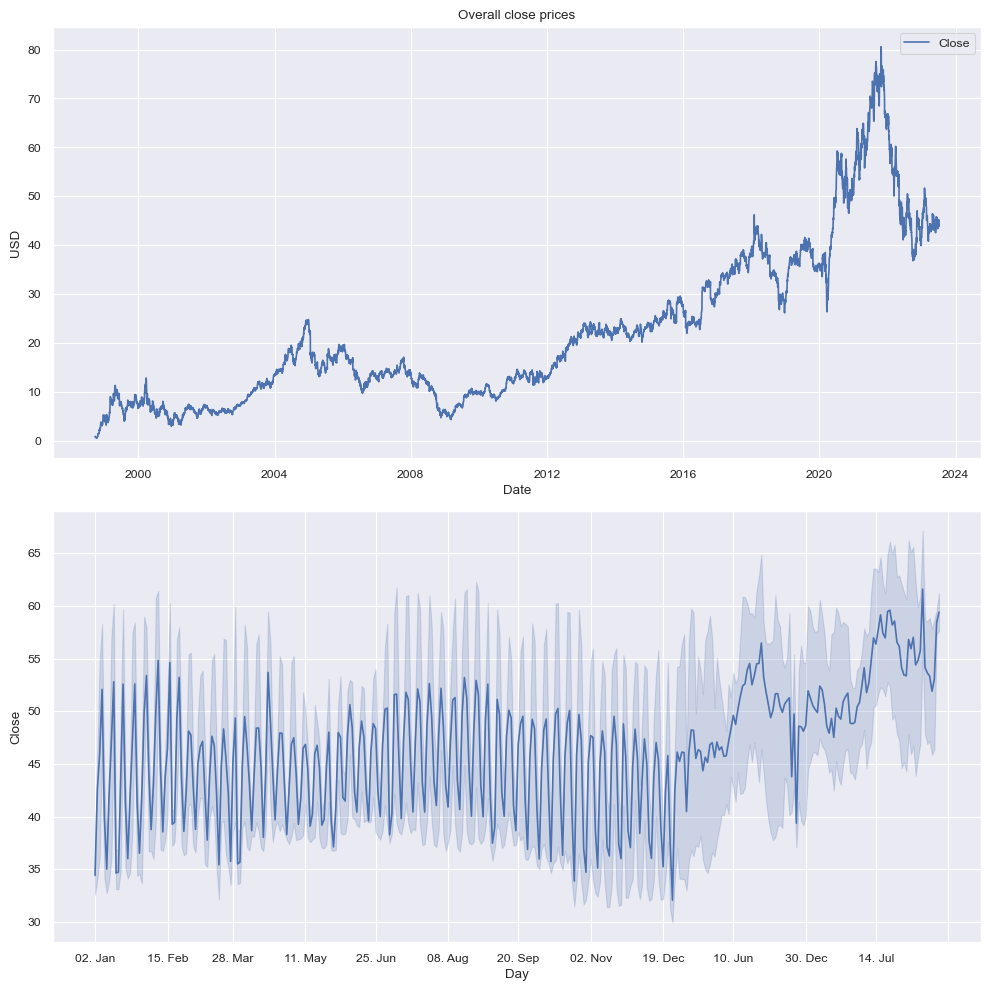

In [205]:


#fig.suptitle(f'Analysis of {ticker.info["longName"]}\n\n', fontsize=25)

#axs[0].set_title('Overall closing price', fontsize=17)
#axs[0].plot(df['Close'], df['Close'].rolling(rolling_resolution).mean()) # .plot(legend=True, label=str(rolling_resolution) + '-day moving average', grid=True)
#axs[0].set_ylabel(ticker.info['currency'])

#plt.subplot(512)
#plt.title('Overall trend', fontsize=17)
#plt.ylabel(ticker.info['currency'])
#decompose.trend.plot(grid=True)

#plt.subplot(513)
#plt.title(f'Annual min/max/mean closing prices last {max_num_of_years} years', fontsize=17)
#plt.fill_between(annualDf.index, annualDf['min'], annualDf['max'], alpha=0.4)
#plt.ylabel(ticker.info['currency'])
#annualDf['mean'].plot(grid=True)

#plt.subplot(514)
#plt.title(f'Annual seasonality last {max_num_of_years} years', fontsize=17)
#plt.axvline(mdates.date2num(dt.datetime(lastYear, dt.date.today().month, dt.date.today().day)), linestyle='dashed')
#plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))
#if seasonalityInPercent:
#    plt.ylabel('%')
#else:
#    plt.ylabel(ticker.info['currency'])
#alpha_value = 1
#for col in annualDf.columns:
#    if col.startswith(periodNames[3]):
#        if seasonalityInPercent:
#            usedAnnualDf = 100 * (annualDf[col] - annualDf[col].iloc[0]) / (annualDf[col].max() - annualDf[col].iloc[0])
#        else:
#            usedAnnualDf = annualDf[col]
#        usedAnnualDf.plot(color='tab:purple', alpha=alpha_value, grid=True)
#        alpha_value = alpha_value * (1 - (2 / numOfYears))

#plt.subplot(515)
#plt.title('Annual monthly mean performance', fontsize=17)
#plt.ylabel(ticker.info['currency'])
#monthlyDf['mean'].plot(kind='bar', yerr=monthlyDf['std'], capsize=4, color=monthlyDf['meanPositive'].map({True: 'tab:green', False: 'tab:red'}), grid=True, rot=0)

#plt.show()

#df['RollingMean'] = df['Close'].rolling(rolling_resolution).mean()

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
sns.set_theme('paper')

sns.lineplot(data=df, dashes=False, ax=axs[0], legend='full')
axs[0].set_title('Overall close prices')
axs[0].set_ylabel(ticker.info['currency'])

#sns.lineplot(data=annualDf[['2022', '2021', '2020', '2019']], ax=axs[1])
#axs[1].set_title(f'Annual close prices of last {max_num_of_years} years')
#axs[1].set_ylabel(ticker.info['currency'])
#axs[1].xaxis.set_major_locator(mdates.MonthLocator())
#axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%b"))

annualDf2 = annualDf.reset_index()
print(annualDf2)

sns.lineplot(data=annualDf2, x='Day', y='Close', errorbar=('pi', 50), ax=axs[1])
axs[1].xaxis.set_major_locator(mdates.MonthLocator())


fig.tight_layout()

